In [1]:
import sys
sys.path.append('/home/ak/Documents/Research/PaperCode/stylised_facts/stylised_facts_data_utilities')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import lob_for_futures as lobFut
from lob_for_futures import *
import os
import matplotlib.pyplot as plt

import numpy as np
from sklearn import linear_model
import collections
from collections import defaultdict
import pickle
import array_to_latex as a2l
import tqdm
import time

from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle as pkl
import fnmatch

import datetime as dt
from datetime import timedelta
import glob
import fathon
from fathon import fathonUtils as fu
from shogun import ST_UNBIASED_FULL,NAM_PERMUTATION, ST_BIASED_FULL
import pyinform as pyinf
import pingouin as pig
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
import time
####
def symbol_file_name_path(symbol, file_idx):
    symbolPath = os.path.join(experimentsDestination, str(symbol))
    file_names =sorted(os.listdir(symbolPath))
    file_name =file_names[file_idx]
    file_path =os.path.join(symbolPath, file_name)
    return file_names, file_path
def n_F(dicts, bar):
    df = pd.DataFrame.from_dict(dicts[str(bar)])
    n = df.index.values
    F = df.median(axis=1).values
    return n, F
def h_params(h_dict, bar):
    h_df = pd.DataFrame.from_dict(h_dict[str(bar)]).T.median(axis=0)
    H_intercept = h_df[1]
    H = h_df[0]
    return H_intercept, H


def open_pickle_filepath(pickle_file):
    pickle_to_file = pickle.load(open(pickle_file, "rb"), encoding='latin1')

    return pickle_to_file

ModuleNotFoundError: No module named 'seaborn'

In [6]:
import shogun

In [7]:
import stylised_facts_data_utilities.mmd as mmd
import stylised_facts_data_utilities.ksd as ksd
import stylised_facts_data_utilities.longtaildistr as ltd
from scipy import stats

In [8]:
## symbol and appropriate quantities ###
dataFolder = lobFut.dataFolder # pick a data folder
print(dataFolder)

quotes =[f for f in os.listdir(dataFolder) if str('_quotes') in f] # seperate quotes and trades
trades =[f for f in os.listdir(dataFolder) if str('_trades') in f]

symbolIdx = 9 # pick a symbol

symbols = [f.split("_")[0] for f in quotes]

symbol = sorted(symbols)[symbolIdx]
print(symbol)
quotesFileCh = os.path.join(dataFolder, quotes[symbolIdx])
tradesFileCh = os.path.join(dataFolder, trades[symbolIdx])

# get common Dates
quotesDates = sorted([f.split(".csv")[0] for f in os.listdir(quotesFileCh)])
tradesDates = sorted([f.split(".csv")[0] for f in os.listdir(tradesFileCh)])

intersectionDates = list(set(quotesDates).intersection(tradesDates))

trades_cols = ['size', 'time', 'type', 'value']


/media/ak/WorkDrive/Data
TU1


In [9]:
experimentsDestination = '/media/ak/T7/MFDFA Experiments/' # where all the MFDFA results are stored
files = os.listdir(os.path.join('/media/ak/T7/MFDFA Experiments/', symbol)) # where the specific MFDFA results are
files # just a printout of which files are in there

['DFA_n_f_valuesvolume_width100calendar_resample200S_bar_20180731_calendar.pkl',
 'DFA_h_dict_valuesvolume_width100calendar_resample200S_bar_20180731_calendar.pkl',
 'MDFA_n_f_valuesvolume_width100calendar_resample200S_bar_20180731_calendar.pkl',
 'MDFA_TAU_DICTvolume_width100calendar_resample200S_bar_20180731_calendar.pkl',
 'MDFA_alpha_spectvolume_width100calendar_resample200S_bar_20180731_calendar.pkl',
 'MDFA_H_dictvolume_width100calendar_resample200S_bar_20180731_calendar.pkl']

In [10]:
## 'MFDFA_H_values_bar_calendar
mfdfa_alpha_spect_pickle_file_path = os.path.join(experimentsDestination,symbol, files[4]) # this is the h_dict mfdfa

mfdfa_tau_dict_file_path = os.path.join(experimentsDestination,symbol, files[3]) # this is the h_dict mfdfa

mfdfa_n_f_file_path = os.path.join(experimentsDestination,symbol,  files[2]) # this is the mfdfa
mfdfa_h_dict_path = os.path.join(experimentsDestination,symbol,  files[5])
print(mfdfa_h_dict_path )

/media/ak/T7/MFDFA Experiments/TU1/MDFA_H_dictvolume_width100calendar_resample200S_bar_20180731_calendar.pkl


In [11]:
# read the DFA Dicts
H_dicts = open_pickle_filepath(mfdfa_tau_dict_file_path)
# returns h_dict[j][i] = [H, H_intercept] # bar/date: H, H_intercept
barIdx =0 #0:tick, 1:volume
bars = ['tick', 'volume', 'dollar', 'calendar']
dates = list(H_dicts[bars[barIdx]].keys())

MFDFA_n_f_dicts = open_pickle_filepath(mfdfa_n_f_file_path)
dicts= open_pickle_filepath(mfdfa_h_dict_path)

In [12]:
bar_choice = bars[barIdx]
# tick bar
mfSpect_tick =list()
alpha_tick =list()
# dollar bar
mfSpect_dollar =list()
alpha_dollar =list()

# calendar bar
mfSpect_calendar =list()
alpha_calendar =list()

# calendar bar
mfSpect_volume =list()
alpha_volume =list()


for i in range(len(dates)):
    mfSpect_tick.append(dicts[str(bar_choice)][dates[i]][0])
    alpha_tick.append(dicts[str(bar_choice)][dates[i]][1])
    # dollar
    mfSpect_dollar.append(dicts['dollar'][dates[i]][0])
    alpha_dollar.append(dicts['dollar'][dates[i]][1])
    # calendar
    mfSpect_calendar.append(dicts['calendar'][dates[i]][0])
    alpha_calendar.append(dicts['calendar'][dates[i]][1])
    # usd volume
    mfSpect_volume.append(dicts['volume'][dates[i]][0])
    alpha_volume.append(dicts['volume'][dates[i]][1])
    

In [13]:
'tick'
mfSpect_tick_df = pd.DataFrame(list(map(np.ravel, mfSpect_tick))).T #take transpose so we can read across dates
alpha_tick_df = pd.DataFrame(list(map(np.ravel, alpha_tick))).T

'dollar'
mfSpect_dollar_df = pd.DataFrame(list(map(np.ravel, mfSpect_dollar))).T
alpha_dollar_df = pd.DataFrame(list(map(np.ravel, alpha_dollar))).T

'calendar'
mfSpect_calendar_df = pd.DataFrame(list(map(np.ravel, mfSpect_calendar))).T
alpha_calendar_df = pd.DataFrame(list(map(np.ravel, alpha_calendar))).T

'volume'
mfSpect_volume_df = pd.DataFrame(list(map(np.ravel, mfSpect_volume))).T
alpha_volume_df = pd.DataFrame(list(map(np.ravel, alpha_volume))).T


In [14]:
from scipy.stats import norm, laplace

def sample_gaussian_vs_laplace(n=220, mu=0.0, sigma2=None, b=np.sqrt(0.5)):    
    # sample from both distributions
    X=norm.rvs(size=n, loc=mu, scale=sigma2)
    Y=laplace.rvs(size=n, loc=mu, scale=b)
    
    return X,Y

In [48]:
choice_variable = np.array(mfSpect_calendar_df.median(axis=1))

In [49]:
X, Y = sample_gaussian_vs_laplace(n=len(choice_variable), mu= np.average(choice_variable), sigma2 = np.std(choice_variable), b=np.sqrt(0.5))

In [51]:
type(choice_variable)

numpy.ndarray

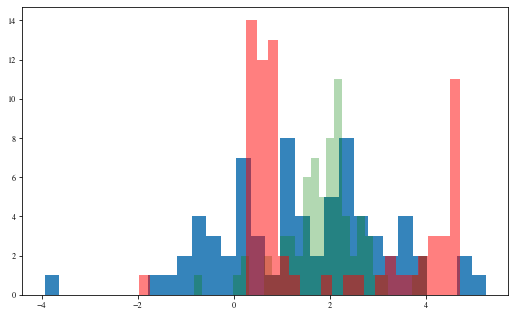

In [56]:
plt.hist(X, alpha=0.9, bins =30)
plt.hist(Y,  alpha=0.3, bins =30, color ='green')
plt.hist(choice_variable, alpha=0.5, color='r', bins =30);

In [53]:
from shogun import RealFeatures, QuadraticTimeMMD, GaussianKernel
samples_p = RealFeatures(X.reshape(1,len(X)))

samples_q = RealFeatures(Y.reshape(1,len(Y)))

samples_z = RealFeatures(choice_variable.reshape(1,len(choice_variable)))

In [57]:
mmd = QuadraticTimeMMD(samples_p, samples_z)
kernel = GaussianKernel(10, 1)
mmd.set_kernel(kernel)
alpha = 0.05

In [58]:
mmd.set_statistic_type(ST_BIASED_FULL)
statistic = mmd.compute_statistic()
mmd.set_null_approximation_method(NAM_PERMUTATION)
mmd.set_num_null_samples(200)
threshold = mmd.compute_threshold(alpha)
p_value = mmd.compute_p_value(statistic)
print(p_value)

0.0


In [59]:
mmd.compute_statistic?

In [61]:
import tensorflow as tf
sigma_median= 1

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
#     print("MMD and ratio:", sess.run(mmd.rbf_mmd2_and_ratio(X,Y, sigma=sigma_median)))